<img style="margin: 0 auto;" src="https://desafiolatam.com/assets/home/logo-academia-bla-790873cdf66b0e681dfbe640ace8a602f5330bec301c409744c358330e823ae3.png">

# Desafio 2 Rendimiento escolar

#### Integrantes
* Catalina Cerda
* José González
* Luis Porras

In [1]:
#Importar librerias
#Manejo de base de datos
import pandas as pd
#Funciones numéricas
import numpy as np
#Librerias de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
#Importe de modulos estadisticos
import scipy.stats as stats
#Analiza los datos perdidos por columna
import missingno

#Importe de statsmodels para la regresión lineal.
import statsmodels.api as sm

#Al importar esta libreria ya no es necesario asignarle valores numéricos a las categorías.
import statsmodels.formula.api as smf

#Ignorar Avisos
import warnings
warnings.filterwarnings("ignore")

#Libreria funciones auxiliares
import utils
#
plt.rcParams["figure.figsize"] = (10,6)

# Hito 1: Sesión Presencial 1, Unidad 7
Completar el punto de Preliminares, así como Aspectos computacionales.

### Desafío 2: Rendimiento escolar
#### Enunciado
Lo contactan de una escuela Portuguesa para generar un modelo que identifique aquellos alumnos
que presentan un bajo desempeño académico, medido en el promedio final del año escolar. Para ello
le envían un archivo con registros sociodemográficos y conductuales de los alumnos dos escuelas
para perfilar a los estudiantes.
De manera adicional la psicopedagoga sugiere inspeccionar una batería de preguntas asociadas a
aspectos ambientales del alumno (de famrel a health ) y ver si éstas se pueden abstraer en
categorías latentes.
### Aspectos adicionales a considerar
* La base de datos presenta una serie de anomalías. En la escuela no tienen buenas prácticas sobre cómo ingresar datos, por lo que existen datos perdidos que están registrados bajo tres categorías: nulidade, sem validade, zero. De manera adicional, hay 3 variables numéricas que se registraron como strings, cuya interpretación en pandas devuelve una estructura de datos genérica. Finalmente, la base está con un encoding distinto al normal y los delimitadores son distintos.
<br>
* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificar las variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.
<br>
* El procedimiento también debe aplicarse para aquelas variables nominales con más de 2 categorías siguiendo la misma lógica.
<br>
* En la parte de modelación descriptiva, se deben generar modelos saturados por cada una de las notas registradas en G1 , G2 y G3.
<br>
* Para la parte de modelación predictiva, se debe generar un modelo para predecir las notas en G3 .

In [2]:
#Cargamos el dataframe y lo asignamos al valor 'df_student'
#Con el argumento sep separamos las celdas de la base de dato que vienen con separado con ' ,'
df_student = pd.read_csv('students.csv', sep='|', encoding='iso-8859-1') 
df_student.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,GP,F,nulidade,U,GT3,A,4,4,at_home,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,1,GP,F,"""17""",U,GT3,T,1,1,at_home,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,2,GP,F,"""15""",U,LE3,T,1,1,at_home,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,3,GP,F,"""15""",U,GT3,T,4,2,health,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,4,GP,F,sem validade,U,GT3,T,3,3,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Primero dropeamos la columna `Unnamed: 0`

In [3]:
df = df_student.drop(columns = 'Unnamed: 0', axis = 1)
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,nulidade,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,sem validade,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Reemplazamos todos los datos mal ingresados (`nulidade`, `sem validade`, `zero`) por `NaN`

In [4]:
df = df.replace('nulidade', np.nan)
df = df.replace('sem validade', np.nan)
df = df.replace('zero',np.nan)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,NaN,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


In [5]:
df['G3'].value_counts('%')

10    0.140306
11    0.119898
0     0.094388
15    0.084184
8     0.081633
13    0.079082
12    0.079082
9     0.068878
14    0.068878
16    0.040816
6     0.038265
18    0.030612
7     0.022959
5     0.017857
17    0.015306
19    0.012755
20    0.002551
4     0.002551
Name: G3, dtype: float64

Reemplazamos los valores `string-numericos` a `Float`

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null object
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc       

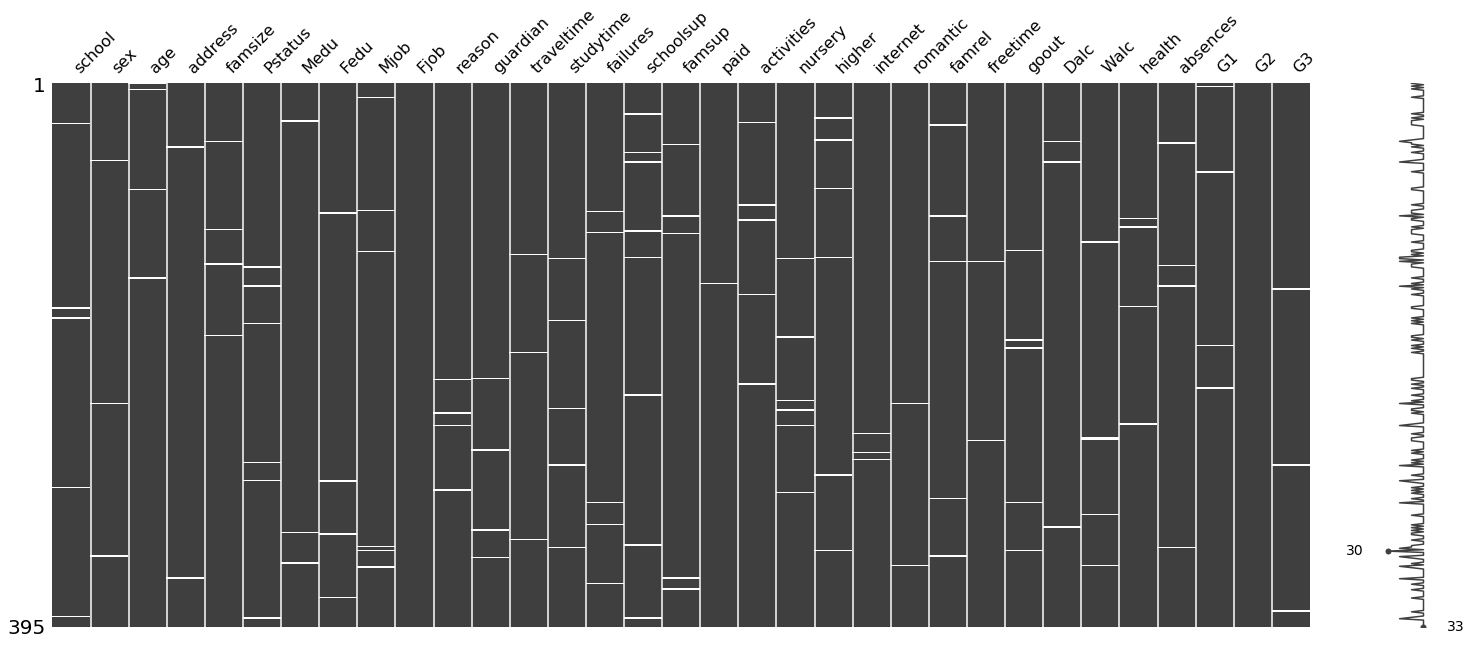

In [7]:
missingno.matrix(df)

In [8]:
df_dropped = df.dropna()

In [9]:
print(f"El porcentaje de datos perdidos si eliminamos todos los N/A es de: {round(len(df_dropped)/len(df)*100, 2)}%")

El porcentaje de datos perdidos si eliminamos todos los N/A es de: 71.9%


Recodificando columna `age` de `String` a `Float`:

In [10]:
df['age'].value_counts()

"16"    101
"17"     98
"15"     82
"18"     81
"19"     24
"20"      3
"22"      1
"21"      1
Name: age, dtype: int64

In [11]:
df['age'] = df['age'].str.replace('\"','')
df['age'].value_counts()

16    101
17     98
15     82
18     81
19     24
20      3
22      1
21      1
Name: age, dtype: int64

In [12]:
df['age'] = df['age'].astype('float')

Recodificando columna `absences` de `String` a `Float`:

In [13]:
df['absences'].value_counts(dropna=False)

0      113
2       64
4       53
6       31
8       22
10      17
14      12
12      11
3        8
16       7
7        7
18       5
5        5
20       4
NaN      4
9        3
15       3
13       3
22       3
11       3
1        3
19       1
26       1
25       1
30       1
17       1
28       1
56       1
38       1
40       1
21       1
54       1
75       1
23       1
24       1
Name: absences, dtype: int64

In [14]:
df['absences'] = df['absences'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

In [15]:
df['Medu'] = df['Medu'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc     

In [16]:
df['Fedu'] = df['Fedu'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc    

In [17]:
df['traveltime'] = df['traveltime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc   

In [18]:
df['studytime'] = df['studytime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc  

In [19]:
df['failures'] = df['failures'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc 

In [20]:
df['famrel'] = df['famrel'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null object
goout         390 non-null object
Dalc

In [21]:
df['freetime'] = df['freetime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [22]:
df['Dalc'] = df['Dalc'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [23]:
df['Walc'] = df['Walc'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [24]:
df['goout'] = df['goout'].str.replace('\"','')
df['goout'] = df['goout'].astype('float')
df['goout'].value_counts()

3.0    128
2.0    103
4.0     83
5.0     53
1.0     23
Name: goout, dtype: int64

In [25]:
df['health'] = df['health'].str.replace('\"','')
df['health'] = df['health'].astype('float')
df['health'].value_counts()

5.0    145
3.0     91
4.0     66
2.0     45
1.0     44
Name: health, dtype: int64

Recodificando columna `G1` de `String` a `Float`:

In [26]:
df['G1'].value_counts(dropna=False)

10     50
8      41
11     38
7      36
12     35
13     33
9      31
14     30
15     24
6      23
16     22
17      8
18      8
5       7
NaN     4
19      3
4       1
3       1
Name: G1, dtype: int64

In [27]:
df['G1'] = df['G1'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

Recodificando columna `G2` de `Int` a `Float`:

In [28]:
df['G2'] = df['G2'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

Recodificando columna `G3` de `String` a `Float`:

In [29]:
df['G3'] = df['G3'].astype('float')
#G3 como tiene muchos promedios 0 por la perdida de datos estos seran remplazados por 0
df['G3'] = df['G3'].replace(0, np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificarlas variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.

Reemplazamos las variables  binarias ('school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic')

In [30]:
df = utils.binarize_columns(df, ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

Analizando Datos de la variable: school
GP    345
MS     45
Name: school, dtype: int64
El valor más frecuente tiene: 345 registros
El valor más frecuente es: GP
Analizando Datos Binarizados de la variable: school
0    345
1     50
Name: b_school, dtype: int64
Analizando Datos de la variable: sex
F    206
M    186
Name: sex, dtype: int64
El valor más frecuente tiene: 206 registros
El valor más frecuente es: F
Analizando Datos Binarizados de la variable: sex
0    206
1    189
Name: b_sex, dtype: int64
Analizando Datos de la variable: address
U    305
R     88
Name: address, dtype: int64
El valor más frecuente tiene: 305 registros
El valor más frecuente es: U
Analizando Datos Binarizados de la variable: address
0    305
1     90
Name: b_address, dtype: int64
Analizando Datos de la variable: famsize
GT3    278
LE3    113
Name: famsize, dtype: int64
El valor más frecuente tiene: 278 registros
El valor más frecuente es: GT3
Analizando Datos Binarizados de la variable: famsize
0    278
1    1

In [31]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'b_school', 'b_sex',
       'b_address', 'b_famsize', 'b_Pstatus', 'b_schoolsup', 'b_famsup',
       'b_paid', 'b_activities', 'b_nursery', 'b_higher', 'b_internet',
       'b_romantic'],
      dtype='object')

* Revisamos los valores que pueden tomar las variables categoricas y le asignamos un valor

In [32]:
df['reason'].value_counts()

course        144
home          108
reputation    103
other          36
Name: reason, dtype: int64

In [33]:
df['guardian'].value_counts()

mother    270
father     89
other      32
Name: guardian, dtype: int64

In [34]:
df['Mjob'].value_counts()

other       138
services    102
at_home      59
teacher      57
health       33
Name: Mjob, dtype: int64

In [35]:
df['Fjob'].value_counts()

other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64

In [36]:
df['c_reason'] = df['reason'].replace(['course', 'home', 'reputation', 'other'],
                                           [0, 1, 2, 3])

In [37]:
df['c_guardian'] = df['guardian'].replace(['mother', 'father', 'other'],
                                           [0, 1, 2])

In [38]:
df['c_Mjob'] = df['Mjob'].replace(['other', 'services', 'at_home', 'teacher', 'health'],
                                           [0, 1, 2,3,4])

In [39]:
df['c_Fjob'] = df['Fjob'].replace(['other', 'services', 'teacher', 'at_home', 'health'],
                                           [0, 1, 2,3,4])

In [40]:
#Para simplificar el analisis futuro eliminaremos las columnas que tengan valores string
df = df.drop('school', axis = 1)
df = df.drop('famsize', axis = 1)
df = df.drop('sex', axis = 1)
df = df.drop('paid', axis = 1)
df = df.drop('activities', axis = 1)
df = df.drop('address', axis = 1)
df = df.drop('Pstatus', axis = 1)
df = df.drop('schoolsup', axis = 1)
df = df.drop('famsup', axis = 1)
df = df.drop('nursery', axis = 1)
df = df.drop('higher', axis = 1)
df = df.drop('internet', axis = 1)
df = df.drop('romantic', axis = 1)
df = df.drop('reason', axis = 1)
df = df.drop('guardian', axis = 1)
df = df.drop('Mjob', axis = 1)
df = df.drop('Fjob', axis = 1)

In [41]:
df.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'b_school', 'b_sex', 'b_address', 'b_famsize', 'b_Pstatus',
       'b_schoolsup', 'b_famsup', 'b_paid', 'b_activities', 'b_nursery',
       'b_higher', 'b_internet', 'b_romantic', 'c_reason', 'c_guardian',
       'c_Mjob', 'c_Fjob'],
      dtype='object')

In [42]:
#Revisamos que todo este en orden
df.sample(5)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,b_paid,b_activities,b_nursery,b_higher,b_internet,b_romantic,c_reason,c_guardian,c_Mjob,c_Fjob
92,16.0,3.0,1.0,1.0,2.0,0.0,3.0,3.0,3.0,2.0,...,0,1,0,0,1,0,1.0,1.0,NaN,0
344,18.0,2.0,3.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,...,0,1,0,0,0,0,0.0,NaN,2.0,0
296,19.0,4.0,4.0,2.0,2.0,0.0,2.0,3.0,4.0,2.0,...,1,0,0,0,0,0,2.0,2.0,4.0,0
197,16.0,3.0,3.0,3.0,1.0,0.0,3.0,3.0,4.0,3.0,...,1,0,0,0,0,0,1.0,1.0,3.0,0
8,15.0,3.0,2.0,1.0,2.0,0.0,4.0,2.0,2.0,1.0,...,1,1,0,0,0,0,1.0,0.0,1.0,0


# Hito 2
Completar el punto de Descripción.
* Elementos a considerar en éste hito:
    * La inspección visual del vector objetivo. (2 puntos)
    * La inspección visual de las variables. (2 puntos)
    * La inspección de datos perdidos en las variables. (1 punto)
    * De ser necesario, se puede iterar en el proceso de preprocesamiento y recodificación de las variables
* Entregable:  Dos notebooks (uno  por  enunciado) con todos los  puntos detallados einterpretados. De  ser  necesario, un  archivo con  extensión .py  con  todas las  funcionesimplementadas.

# Variable de los vectores objetivos

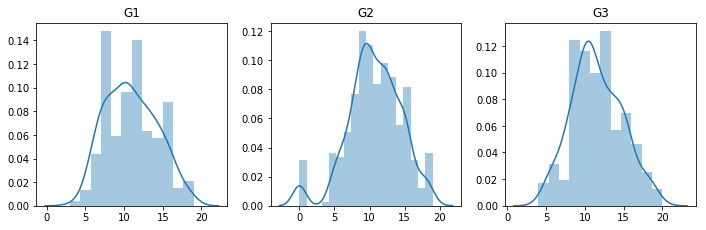

In [43]:
utils.visualize_rows(df.filter(['G1', 'G2', 'G3']))

**conclusiones:** 
Utilizamos los gráficos de histograma porque tenemos que los vectores son variables continuas.
* En el gráfico de `G1` nos muestra que tiene una tendecia a la normal.
* En el gráfico de `G2` nos muestra que el tiene una forma que se que parece a la normal, esto se debe a que hubo muchos 0 en la segunda prueba.
* En el gráfico de `G2` nos muestra que tiene una forma bimodal.

## Variables binarias
**conclusiones:** Para el análisis de variables binariaz usamos histogramas, esto se debe a que las variables binarias son discretas. <br>
También revisamos con 'missigno.matrix(df_escolar)' para ver si eliminar los elementos 'Nan' son significativos, pero revisando la matriz no consideramos que sea significativa la perdida de los valores 'Nan'. 

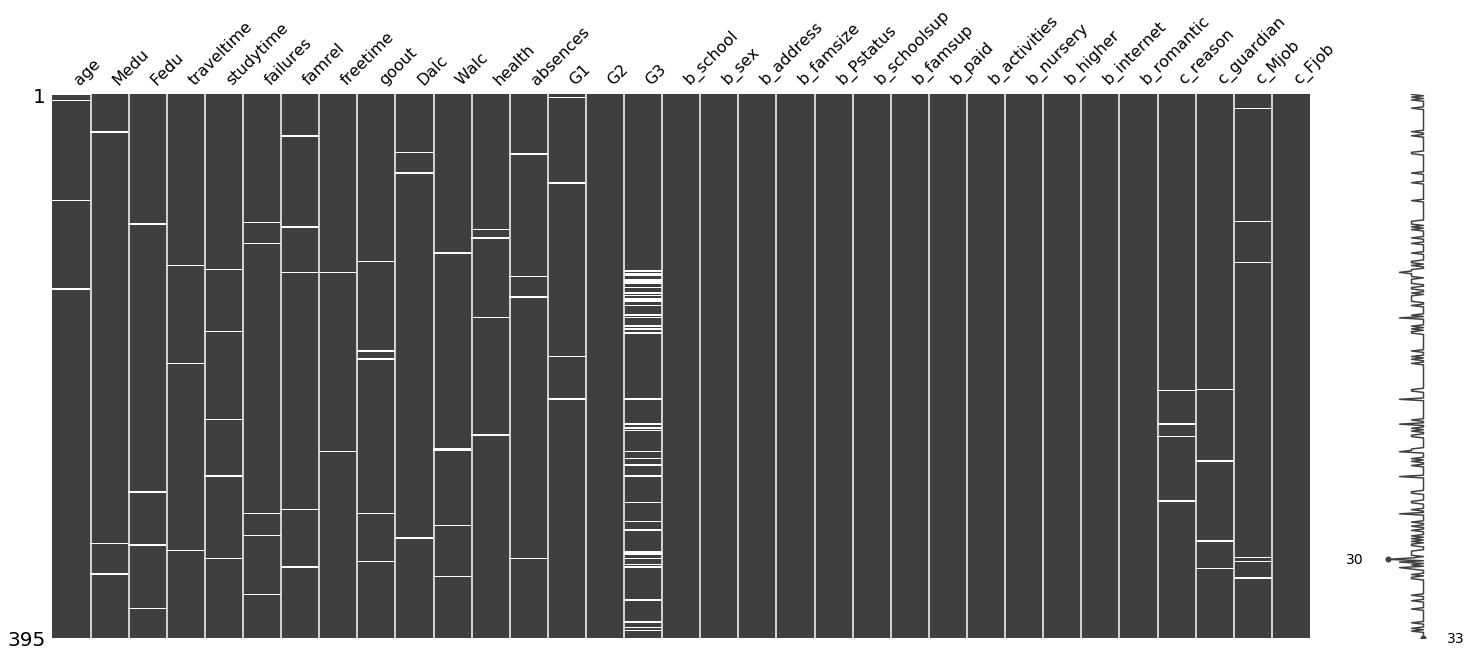

In [44]:
missingno.matrix(df)

In [45]:
utils.visualize_rows(df.filter(['school', 'sex', 'address']))

<Figure size 720x432 with 0 Axes>

In [46]:
utils.visualize_rows(df.filter(['famsize', 'Pstatus', 'schoolsup']))

<Figure size 720x432 with 0 Axes>

In [47]:
utils.visualize_rows(df.filter(['nursery', 'higher', 'internet']))

<Figure size 720x432 with 0 Axes>

In [48]:
utils.visualize_rows(df.filter(['romantic']))

<Figure size 720x432 with 0 Axes>

## Variables categoricas
**conclusiones:** Para el análisis de variables categoricas usamos histogramas, esto se debe a que las variables categoricas pueden tomar valores discretos. <br>
También revisamos con 'missigno.matrix(df_escolar)' para ver si al eliminar los elementos 'NaN' provocamos un cambio significativos, pero revisando la matriz no consideramos que el eliminar los datos 'NaN' por columna sea significativa la perdida de los valores 'NaN'. 

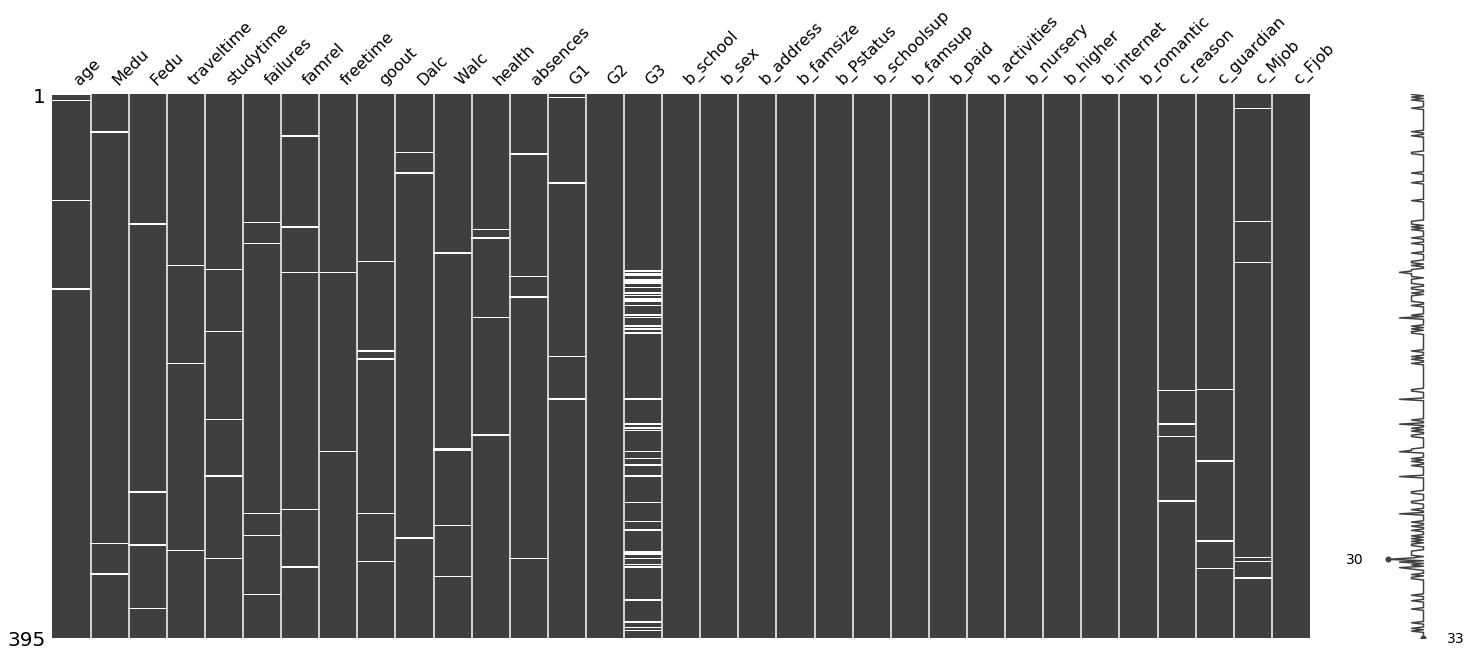

In [49]:
missingno.matrix(df)

In [50]:
utils.visualize_rows(df.filter(['Mjob', 'Fjob']))

<Figure size 720x432 with 0 Axes>

In [51]:
utils.visualize_rows(df.filter(['reason', 'guardian']))

<Figure size 720x432 with 0 Axes>

# Hito 3
Completar el punto de **Modelación descriptiva** .
* Elementos a considerar en éste hito:
     * La modelación mediante regresión de ambos problemas. (2 puntos)
     * La interpretación de los principales regresores en cada problema. (2 puntos)
     * La definición de las estrategias de Modelación predictiva. (1 punto)

Preparamos la regresión para variables binariaz, lo primero es graficar con boxplot para ver si hay algina relación en la que el eje Y es nuestra variable dependiente, en este caso 'G3' y las variables independientes iran en el eje X
* Lo primero es comprobar si la variable tiene una forma de normal

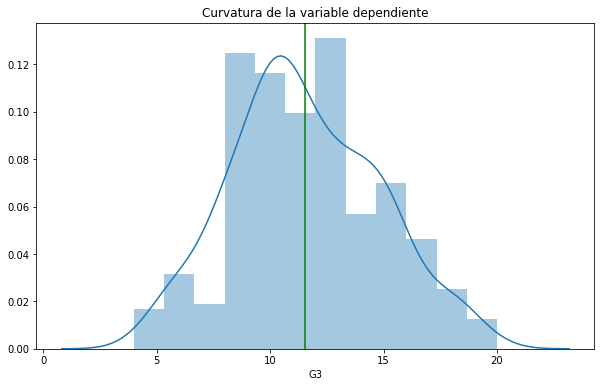

In [52]:
sns.distplot(df['G3'].dropna())
dfm = df['G3'].mean()
plt.title('Curvatura de la variable dependiente')
plt.axvline(dfm, color = 'green')

* Al ver el gráfico se puede concluir que el modelo tiende a la normal, ya que tiene una forma similar a la de una campana y el promedio es casi igual a la moda.
* Para comprobar la normalidad utilizamos los gráficos 'QQ' para ver como se posicionan los datos con respecto a la recta

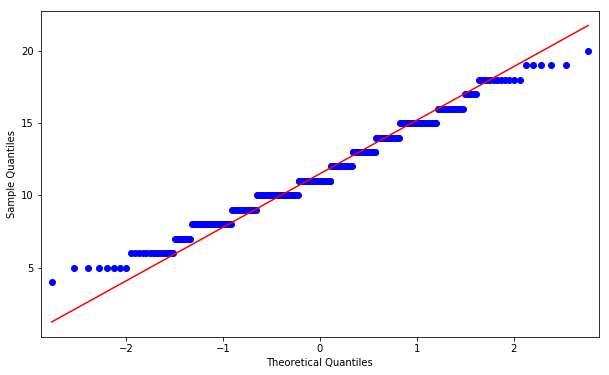

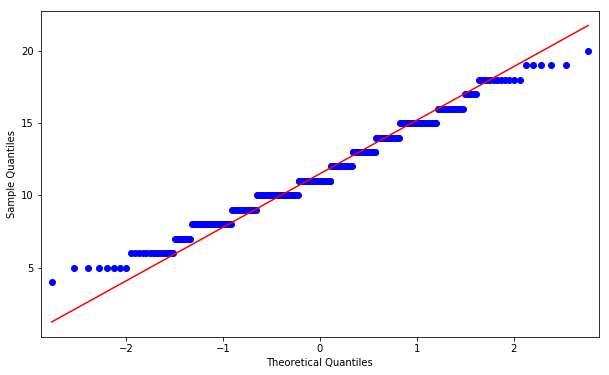

In [53]:
sm.qqplot(df['G3'].dropna(),line = 'q')

**Conclusión:** A partir del los análisis gráficos podemos decir que nuestra variable dependiente `G3` tiende a la normal.

* A continuación realizaremos un análisis descriptivo de la regresión lineal y su respectiva interpretación.

+ Definimos como intervalos de confianza un 90%, por lo tanto todas las variables que tengan un '**P > |t|**' que sea muy mayor a 0,05 seran eliminadas, con excepción de las variables sean mayores a 0,05 pero no mayores a 0,06.

In [54]:
#Asignamos la función de regresión a la variable 'modelo'
modelo = smf.ols('G3 ~ age + Medu + Fedu + traveltime + studytime + failures + famrel + freetime + goout + Dalc + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob ', data = df)
#Con la función 'fit' se infieren los parametro del modelo y el intercepto
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     3.489
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           3.63e-08
Time:                        18:04:49   Log-Likelihood:                -725.43
No. Observations:                 298   AIC:                             1511.
Df Residuals:                     268   BIC:                             1622.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.8882      3.110      3.823      0.000       5.766      18.010
age             -0.0090      0.174     -0.052      0.959      -0.352       0.334
Medu             0.3074      0.231      1.328      0.185      -0.148       0.763
Fedu             0.0921      0.219      0.420      0.675      -0.340       0.524
traveltime       0.0796      0.284      0.280      0.780      -0.480       0.639
studytime        0.3750      0.237      1.581      0.115      -0.092       0.842
failures        -0.8218      0.300     -2.737      0.007      -1.413      -0.231
famrel           0.1635      0.204      0.802      0.424      -0.238       0.565
freetime         0.0451      0.184      0.245      0.806      -0.317       0.407
goout           -0.5786      0.189     -3.056      0.002      -0.951      -0.206
Dalc             0.0062      0.268      0.023      0.982      -0.521       0.533
Walc            -0.0953      0.201     -0.475      0.635      -0.490       0.300
health          -0.2191      0.129     -1.699      0.090      -0.473       0.035
absences        -0.0669      0.022     -3.024      0.003      -0.110      -0.023
b_school        -0.6010      0.610     -0.985      0.326      -1.802       0.600
b_sex            0.4624      0.404      1.144      0.254      -0.333       1.258
b_address       -0.5638      0.473     -1.193      0.234      -1.494       0.367
b_famsize        0.4258      0.403      1.057      0.291      -0.367       1.219
b_Pstatus        0.2329      0.572      0.407      0.684      -0.893       1.359
b_schoolsup     -1.4793      0.490     -3.020      0.003      -2.444      -0.515
b_famsup         0.6043      0.391      1.545      0.124      -0.166       1.374
b_paid          -0.5801      0.380     -1.525      0.128      -1.329       0.169
b_activities     0.2822      0.364      0.776      0.438      -0.434       0.998
b_nursery        0.2750      0.440      0.625      0.532      -0.591       1.141
b_higher        -0.8525      0.780     -1.093      0.275      -2.388       0.682
b_internet      -0.5490      0.480     -1.145      0.253      -1.493       0.395
c_reason         0.1332      0.177      0.751      0.453      -0.216       0.483
c_guardian       0.0105      0.314      0.033      0.973      -0.608       0.629
c_Mjob           0.1359      0.150      0.908      0.365      -0.159       0.430
c_Fjob           0.1517      0.178      0.851      0.395      -0.199       0.503
==============================================================================
Omnibus:                        2.229   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                2.301
Skew:                           0.202   Prob(JB):                        0.317
Kurtosis:                       2.851   Cond. No.                         376.
===============

* Como el regresor tiene muchas variables que estan fuera de el intervalo de cofianza se eliminaran las 4 con mayor '**P > |t|**' y se repetira el proceso hasta que todas las variables esten dentro de la zona 

In [55]:
#se elimina 'age', 'Dalc', 'c_guardian' y 'freetime'
modelo = smf.ols('G3 ~ Medu + Fedu + traveltime + studytime + failures + famrel + goout + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_Mjob + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4.308
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           4.55e-10
Time:                        18:04:49   Log-Likelihood:                -751.73
No. Observations:                 309   AIC:                             1555.
Df Residuals:                     283   BIC:                             1653.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.0944      1.443      8.380      0.000       9.254      14.935
Medu             0.3044      0.216      1.406      0.161      -0.122       0.731
Fedu             0.0836      0.210      0.398      0.691      -0.330       0.497
traveltime       0.0532      0.276      0.193      0.847      -0.490       0.596
studytime        0.3659      0.225      1.629      0.104      -0.076       0.808
failures        -0.8323      0.280     -2.975      0.003      -1.383      -0.282
famrel           0.1264      0.194      0.651      0.516      -0.256       0.509
goout           -0.5675      0.177     -3.198      0.002      -0.917      -0.218
Walc            -0.1176      0.162     -0.724      0.470      -0.437       0.202
health          -0.1973      0.126     -1.567      0.118      -0.445       0.051
absences        -0.0669      0.021     -3.183      0.002      -0.108      -0.026
b_school        -0.5240      0.548     -0.957      0.339      -1.602       0.554
b_sex            0.5901      0.382      1.543      0.124      -0.163       1.343
b_address       -0.5914      0.450     -1.313      0.190      -1.478       0.295
b_famsize        0.5198      0.383      1.359      0.175      -0.233       1.273
b_Pstatus        0.0808      0.556      0.145      0.884      -1.013       1.175
b_schoolsup     -1.4969      0.459     -3.259      0.001      -2.401      -0.593
b_famsup         0.4881      0.374      1.306      0.193      -0.248       1.224
b_paid          -0.6562      0.367     -1.787      0.075      -1.379       0.066
b_activities     0.1886      0.351      0.538      0.591      -0.502       0.879
b_nursery        0.3144      0.429      0.734      0.464      -0.529       1.158
b_higher        -0.8492      0.763     -1.113      0.267      -2.351       0.653
b_internet      -0.6353      0.453     -1.401      0.162      -1.528       0.257
c_reason         0.1253      0.169      0.740      0.460      -0.208       0.459
c_Mjob           0.1259      0.143      0.881      0.379      -0.155       0.407
c_Fjob           0.2060      0.169      1.216      0.225      -0.127       0.540
==============================================================================
Omnibus:                        2.693   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.759
Skew:                           0.221   Prob(JB):                        0.252
Kurtosis:                       2.860   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
#se elimina 'traveltime', 'b_Pstatus', 'Fedu' y 'b_activities'
modelo = smf.ols('G3 ~ Medu + studytime + failures + famrel + goout + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_schoolsup + b_famsup + b_paid + b_nursery + b_higher + b_internet + c_reason + c_Mjob + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     5.600
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           1.25e-12
Time:                        18:04:49   Log-Likelihood:                -769.91
No. Observations:                 317   AIC:                             1584.
Df Residuals:                     295   BIC:                             1667.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3822      1.248      9.925      0.000       9.927      14.837
Medu            0.3439      0.173      1.985      0.048       0.003       0.685
studytime       0.3836      0.213      1.798      0.073      -0.036       0.804
failures       -0.8434      0.271     -3.117      0.002      -1.376      -0.311
famrel          0.1285      0.190      0.678      0.499      -0.245       0.502
goout          -0.5944      0.171     -3.471      0.001      -0.931      -0.257
Walc           -0.1057      0.157     -0.672      0.502      -0.415       0.204
health         -0.1918      0.122     -1.570      0.118      -0.432       0.049
absences       -0.0670      0.021     -3.254      0.001      -0.108      -0.026
b_school       -0.5557      0.521     -1.066      0.287      -1.581       0.470
b_sex           0.6034      0.365      1.654      0.099      -0.114       1.321
b_address      -0.5965      0.420     -1.420      0.157      -1.423       0.230
b_famsize       0.5746      0.360      1.594      0.112      -0.135       1.284
b_schoolsup    -1.5141      0.448     -3.383      0.001      -2.395      -0.633
b_famsup        0.4215      0.360      1.172      0.242      -0.286       1.129
b_paid         -0.6876      0.355     -1.936      0.054      -1.386       0.011
b_nursery       0.3080      0.416      0.740      0.460      -0.511       1.127
b_higher       -0.8292      0.750     -1.105      0.270      -2.306       0.648
b_internet     -0.6201      0.441     -1.405      0.161      -1.489       0.249
c_reason        0.1179      0.165      0.714      0.476      -0.207       0.443
c_Mjob          0.1323      0.139      0.951      0.343      -0.142       0.406
c_Fjob          0.2286      0.157      1.453      0.147      -0.081       0.538
==============================================================================
Omnibus:                        2.594   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                2.640
Skew:                           0.217   Prob(JB):                        0.267
Kurtosis:                       2.889   Cond. No.                         94.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
#se elimina 'Walc', 'famrel', 'b_nursery' y 'c_reason'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + health + absences + b_school +b_sex + b_address + b_famsize + b_schoolsup + b_famsup + b_paid + b_higher + b_internet + c_Mjob + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     6.602
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           2.03e-13
Time:                        18:04:49   Log-Likelihood:                -804.73
No. Observations:                 329   AIC:                             1645.
Df Residuals:                     311   BIC:                             1714.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6862      1.009     12.569      0.000      10.700      14.672
Medu            0.3395      0.169      2.009      0.045       0.007       0.672
studytime       0.3921      0.209      1.873      0.062      -0.020       0.804
failures       -0.9448      0.264     -3.585      0.000      -1.463      -0.426
goout          -0.5344      0.148     -3.602      0.000      -0.826      -0.242
health         -0.2045      0.119     -1.723      0.086      -0.438       0.029
absences       -0.0687      0.020     -3.376      0.001      -0.109      -0.029
b_school       -0.6363      0.517     -1.231      0.219      -1.654       0.381
b_sex           0.5306      0.354      1.500      0.135      -0.165       1.226
b_address      -0.4897      0.408     -1.200      0.231      -1.293       0.314
b_famsize       0.3245      0.350      0.927      0.355      -0.364       1.013
b_schoolsup    -1.4079      0.444     -3.173      0.002      -2.281      -0.535
b_famsup        0.6252      0.354      1.767      0.078      -0.071       1.321
b_paid         -0.6294      0.346     -1.821      0.070      -1.309       0.051
b_higher       -0.7457      0.752     -0.992      0.322      -2.225       0.734
b_internet     -0.6460      0.442     -1.461      0.145      -1.516       0.224
c_Mjob          0.1642      0.135      1.215      0.225      -0.102       0.430
c_Fjob          0.2109      0.153      1.382      0.168      -0.089       0.511
==============================================================================
Omnibus:                        2.564   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.627
Skew:                           0.191   Prob(JB):                        0.269
Kurtosis:                       2.785   Cond. No.                         74.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
#se elimina 'b_famsize', 'b_higher', 'c_Mjob' y 'b_address'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + health + absences + b_school +b_sex + b_schoolsup + b_famsup + b_paid + b_internet + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     8.187
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           3.09e-14
Time:                        18:04:49   Log-Likelihood:                -820.00
No. Observations:                 334   AIC:                             1668.
Df Residuals:                     320   BIC:                             1721.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.4184      0.983     12.633      0.000      10.484      14.352
Medu            0.4183      0.157      2.672      0.008       0.110       0.726
studytime       0.3896      0.207      1.882      0.061      -0.018       0.797
failures       -0.9925      0.260     -3.810      0.000      -1.505      -0.480
goout          -0.5137      0.148     -3.470      0.001      -0.805      -0.222
health         -0.1815      0.118     -1.541      0.124      -0.413       0.050
absences       -0.0711      0.020     -3.551      0.000      -0.110      -0.032
b_school       -0.7474      0.488     -1.531      0.127      -1.708       0.213
b_sex           0.5490      0.349      1.574      0.116      -0.137       1.235
b_schoolsup    -1.5027      0.438     -3.435      0.001      -2.363      -0.642
b_famsup        0.6958      0.350      1.990      0.047       0.008       1.384
b_paid         -0.4885      0.339     -1.440      0.151      -1.156       0.179
b_internet     -0.7653      0.430     -1.781      0.076      -1.610       0.080
c_Fjob          0.2632      0.144      1.833      0.068      -0.019       0.546
==============================================================================
Omnibus:                        3.026   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.961
Skew:                           0.183   Prob(JB):                        0.227
Kurtosis:                       2.719   Cond. No.                         72.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#se elimina 'b_school', 'b_paid', 'health' y 'b_internet'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + absences +b_sex + b_schoolsup + b_famsup + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     10.66
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           1.65e-14
Time:                        18:04:49   Log-Likelihood:                -833.78
No. Observations:                 337   AIC:                             1688.
Df Residuals:                     327   BIC:                             1726.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.9529      0.840     13.046      0.000       9.301      12.605
Medu            0.4659      0.155      2.998      0.003       0.160       0.772
studytime       0.4402      0.206      2.134      0.034       0.034       0.846
failures       -1.0502      0.257     -4.090      0.000      -1.555      -0.545
goout          -0.4964      0.149     -3.341      0.001      -0.789      -0.204
absences       -0.0634      0.020     -3.171      0.002      -0.103      -0.024
b_sex           0.6039      0.345      1.750      0.081      -0.075       1.283
b_schoolsup    -1.3684      0.436     -3.136      0.002      -2.227      -0.510
b_famsup        0.7685      0.336      2.288      0.023       0.108       1.429
c_Fjob          0.2335      0.145      1.613      0.108      -0.051       0.518
==============================================================================
Omnibus:                        3.479   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.482
Skew:                           0.215   Prob(JB):                        0.175
Kurtosis:                       2.748   Cond. No.                         59.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
#se elimina 'c_Fjob' y 'b_sex'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + absences + b_schoolsup + b_famsup', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     12.81
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           1.47e-14
Time:                        18:04:49   Log-Likelihood:                -836.52
No. Observations:                 337   AIC:                             1689.
Df Residuals:                     329   BIC:                             1720.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.4728      0.802     14.300      0.000       9.895      13.051
Medu            0.5250      0.154      3.409      0.001       0.222       0.828
studytime       0.3578      0.198      1.811      0.071      -0.031       0.747
failures       -1.0133      0.258     -3.935      0.000      -1.520      -0.507
goout          -0.5031      0.149     -3.371      0.001      -0.797      -0.210
absences       -0.0698      0.020     -3.510      0.001      -0.109      -0.031
b_schoolsup    -1.4244      0.432     -3.301      0.001      -2.273      -0.575
b_famsup        0.8040      0.336      2.393      0.017       0.143       1.465
==============================================================================
Omnibus:                        2.821   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.826
Skew:                           0.185   Prob(JB):                        0.243
Kurtosis:                       2.747   Cond. No.                         56.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
#se elimina 'studytime'
modelo = smf.ols('G3 ~ Medu + failures + goout + absences + b_schoolsup + b_famsup', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     14.47
Date:                Sat, 14 Sep 2019   Prob (F-statistic):           1.11e-14
Time:                        18:04:49   Log-Likelihood:                -844.53
No. Observations:                 340   AIC:                             1703.
Df Residuals:                     333   BIC:                             1730.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3364      0.657     18.767      0.000      11.043      13.629
Medu            0.5169      0.153      3.376      0.001       0.216       0.818
failures       -1.0404      0.250     -4.158      0.000      -1.532      -0.548
goout          -0.5231      0.148     -3.525      0.000      -0.815      -0.231
absences       -0.0717      0.020     -3.623      0.000      -0.111      -0.033
b_schoolsup    -1.3982      0.431     -3.246      0.001      -2.246      -0.551
b_famsup        0.7198      0.331      2.176      0.030       0.069       1.370
==============================================================================
Omnibus:                        2.559   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.616
Skew:                           0.185   Prob(JB):                        0.270
Kurtosis:                       2.781   Cond. No.                         46.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:** Apartir del modelo generado podemos decir con un 90% confianza la variable dependiente (`G3`) de la muestra se explica en 20,7% por el nivel educacional de la madre (`Medu`),  por el número de clases reprobadas (`failures`), por la salidas con amigos (`goout`), la cantidad de ausencias escolares (`absences`) la escuela del estudiante (`b_schoolsup`) y el apoyo educacional familiar (`famsup`), con un error standar de de 0,657 y tiene un intercepto (donde la recta corta al eje $Y$.) que empieza en el punto 12,3364.<br>
Peso de cada vairable ($\beta$) :
* `absences`: $\beta_{absences} = -0,0679$
* `failures`: $\beta_{failures} = -1,2382$
* `goout`:$\beta_{goout} = -0,4465$
* `b_schoolsup`:$\beta_{bschoolsup} =-1,567$

**Definición de las estrategias de Modelación predictiva**:<br>
* El modelo que utilizaremos es la regresión lineal que importamos de sklearn, especificamente el modulo 'LinearRegression'<br>

* Para poder medir el desempeño del modelo utilizaremos la libreria Scikit learn especificamente las funciones 'mean_squared_error' y 'r2_score'.

# Hito 4
Completar el punto de **Modelación predictiva**.
* Elementos a considerar en éste hito:
    * La preparación del ambiente de trabajo (imports, separación de muestras) para implementar modelos de predicción. (1 punto)
    * La implementación de por lo menos tres modelos predictivos. (2 puntos)
    * El reporte del mejor modelo predictivo en base a los resultados. (2 puntos)

__Importamos los principales módulos de 'sklearn':__

In [62]:
#Modelo de regresión lineal.
from sklearn.linear_model import LinearRegression
#Metricas del modelo.
from sklearn.metrics import mean_squared_error, r2_score

__Dividimos la muestra en 2 partes, la muestra de entrenamiento (representa un 67% de la muestra global) y la muestra de entrenamiento (representa un 33% de la muestra).__

In [63]:
#Medimos el largo del dataframe.
print('El largo de la muestra es ' ,len(df)) 
#Calculamos el 67% del total del dataframe.
print('El 67% de la muestra corresponde a ' ,round((len(df)*.67), 0))
#Calculamos el 33% de la muestra.
print('El 33% de la muestra corresponde a ',round(len(df)- (len(df)*.67), 0))

El largo de la muestra es  395
El 67% de la muestra corresponde a  265.0
El 33% de la muestra corresponde a  130.0


In [64]:
#Separamos la variable dependiente 'G3' de la muestra de entrenamiento.
df_m = df.drop(['G3'], axis = 1)
#Separamos la muestra de entrenamiento con la muestra de prueba.
#Muestra de entrenamiento.
x_mat_train = df_m[:-130]
#Muestra de prueba.
x_mat_test = df_m[-130:]

print('El tamaño de la muestra de entrenamiento es ', len(x_mat_train))
print('El tamaño de la muestra de prueba es ', len(x_mat_test))

El tamaño de la muestra de entrenamiento es  265
El tamaño de la muestra de prueba es  130


In [65]:
#Repetimos el proceso anterior con la muestra de la variable independiente 'G3'.
#Muestra de entrenamiento.
y_mat_train = df['G3'][:-130]
#Muestra de prueba.
y_mat_test = df['G3'][-130:]

print('El tamaño de la muestra de entrenamiento es ', len(y_mat_train))
print('El tamaño de la muestra de prueba es ', len(y_mat_test))

El tamaño de la muestra de entrenamiento es  265
El tamaño de la muestra de prueba es  130


In [73]:
#Como el dataframe que utilizamos tiene muchos datos perdidos vamos a tener que imputar la data
#Para los casos binarioz y categoricos se imputara por frecuencia y en los casos numericos se imputara por el promedio
print(df['b_school'].value_counts())
df['b_school'] = df.replace(NaN, 0)

0    345
1     50
Name: b_school, dtype: int64


NameError: name 'NaN' is not defined

In [68]:
df.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'b_school', 'b_sex', 'b_address', 'b_famsize', 'b_Pstatus',
       'b_schoolsup', 'b_famsup', 'b_paid', 'b_activities', 'b_nursery',
       'b_higher', 'b_internet', 'b_romantic', 'c_reason', 'c_guardian',
       'c_Mjob', 'c_Fjob'],
      dtype='object')

In [66]:
#Ahora se análiza que es lo que esta pasando con el modelo generado por 'sklearn'.
#Creamos la variable que almacena la información de la regresion lineal con 'sklearn'.
modelo_sklearn_rl = LinearRegression().fit(x_mat_train, y_mat_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').